### 🤖 What are Multi-Agent RAG Systems?
A Multi-Agent RAG System splits the RAG pipeline into multiple specialized agents — each responsible for a specific role — and enables them to collaborate on a single query or task.

#### 1. 📋 Multi-Agent Network RAG System with LangGraph
Project Overview

A beginner-friendly Retrieval-Augmented Generation (RAG) system that uses a multi-agent architecture to intelligently answer questions from your documents. Built with LangGraph v0.3 for workflow orchestration and OpenAI for language understanding.

What It Does

Transforms your documents (PDFs, text files) into a searchable knowledge base that can answer questions intelligently using AI. Simply upload documents and ask questions in natural language - the system finds relevant information and generates comprehensive answers.
Key Features

- 📚 Multi-Format Support: Handles PDF and text documents
- 🤖 3-Agent Architecture: Specialized agents for document processing, retrieval, and answer generation
- 🔍 Smart Search: Vector-based semantic search finds relevant information
- 💬 Natural Language Q&A: Ask questions in plain English


In [1]:
"""
STEP 3: Environment Setup
Load API credentials securely from environment variables.
"""

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get Google API key with error handling
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY not found in environment variables")
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
if not TAVILY_API_KEY:
    raise ValueError("TAVILY_API_KEY not found in environment variables")
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
if not LANGSMITH_API_KEY:
    raise ValueError("LANGSMITH_API_KEY not found in environment variables")

print("✓ API keys loaded successfully")

✓ API keys loaded successfully


In [2]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

# Initialize Google embeddings model for vector representation
embedding_model = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001", 
    google_api_key=GOOGLE_API_KEY
)


# Initialize Google's Gemini model for response generation
llm = ChatGoogleGenerativeAI(
    google_api_key=GOOGLE_API_KEY,
    model="gemini-2.0-flash",    # Latest fast Gemini model for quick reranking
    temperature=0,               # Deterministic output for consistency in ranking
    max_tokens=None,            # Use model default token limit
    timeout=None,               # No timeout limit for ranking requests
    max_retries=2,              # Retry failed requests twice
)

print("✓ Gemini model initialized for reranking")

/home/bjit/Desktop/Storage01/SelfDevelopment/Rag_Course/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Gemini model initialized for reranking


E0000 00:00:1759133784.247775   28581 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1759133784.252734   28581 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [3]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain.document_loaders import TextLoader
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [4]:
tavily_tool=TavilySearch(max_results=5)

In [5]:
### generic function to create a retrieval tool
import time
from langchain.agents import Tool

def make_retriever_tool_from_text(file,name,desc):
    docs=TextLoader(file,encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
    
    # Handle Google API rate limiting for free tier (5 requests per 2 seconds)
    # Process chunks in batches of 5 with 2-second delays
    batch_size = 5
    all_embeddings = []
    
    print(f"📊 Processing {len(chunks)} chunks in batches of {batch_size}...")
    
    for i in range(0, len(chunks), batch_size):
        batch = chunks[i:i+batch_size]
        print(f"🔄 Processing batch {i//batch_size + 1}/{(len(chunks) + batch_size - 1)//batch_size} ({len(batch)} chunks)")
        
        # Create vector store for this batch
        if i == 0:
            # Create initial vector store with first batch
            vs = FAISS.from_documents(batch, embedding_model)
        else:
            # Add subsequent batches to existing vector store
            batch_vs = FAISS.from_documents(batch, embedding_model)
            vs.merge_from(batch_vs)
        
        # Sleep to respect rate limits (except for the last batch)
        if i + batch_size < len(chunks):
            print("⏳ Waiting 2 seconds for API rate limit...")
            time.sleep(2)
    
    print(f"✅ Successfully created vector store with {len(chunks)} chunks")
    retriever = vs.as_retriever()

    def tool_func(query:str)->str:
        print(f"📚 Using tool: {name}")
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)
    
    return Tool(name=name,description=desc,func=tool_func)


internal_tool_1=make_retriever_tool_from_text(file="research_notes.txt",
                                              name="InternalResearchNotes",
                                              desc="Search internal research notes for experimental results")

internal_tool_1

📊 Processing 24 chunks in batches of 5...
🔄 Processing batch 1/5 (5 chunks)
⏳ Waiting 2 seconds for API rate limit...
🔄 Processing batch 2/5 (5 chunks)
⏳ Waiting 2 seconds for API rate limit...
🔄 Processing batch 3/5 (5 chunks)
⏳ Waiting 2 seconds for API rate limit...
🔄 Processing batch 4/5 (5 chunks)
⏳ Waiting 2 seconds for API rate limit...
🔄 Processing batch 5/5 (4 chunks)
✅ Successfully created vector store with 24 chunks


Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x7090143e60c0>)

In [6]:
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [7]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

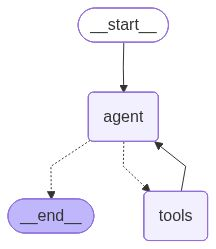

In [8]:
### Reaearch agent and node

research_agent=create_react_agent(
    llm,
    tools=[internal_tool_1,tavily_tool],
    prompt=make_system_prompt("You can only do research. Use the tool that you are binded with, you can use both of them" \
    " You are working with a content writer colleague.")
)

research_agent



In [9]:
## Reaearch node
from typing import Literal
def research_node(state:MessagesState)-> Command[Literal["blog_generator",END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "blog_generator")

    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


In [10]:
### Blog write agent
blog_agent=create_react_agent(
    llm,
    tools=[],
    prompt=make_system_prompt(
        "You can only write a detailed blog. You are working with a researcher colleague."
    )
)

def blog_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = blog_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="blog_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

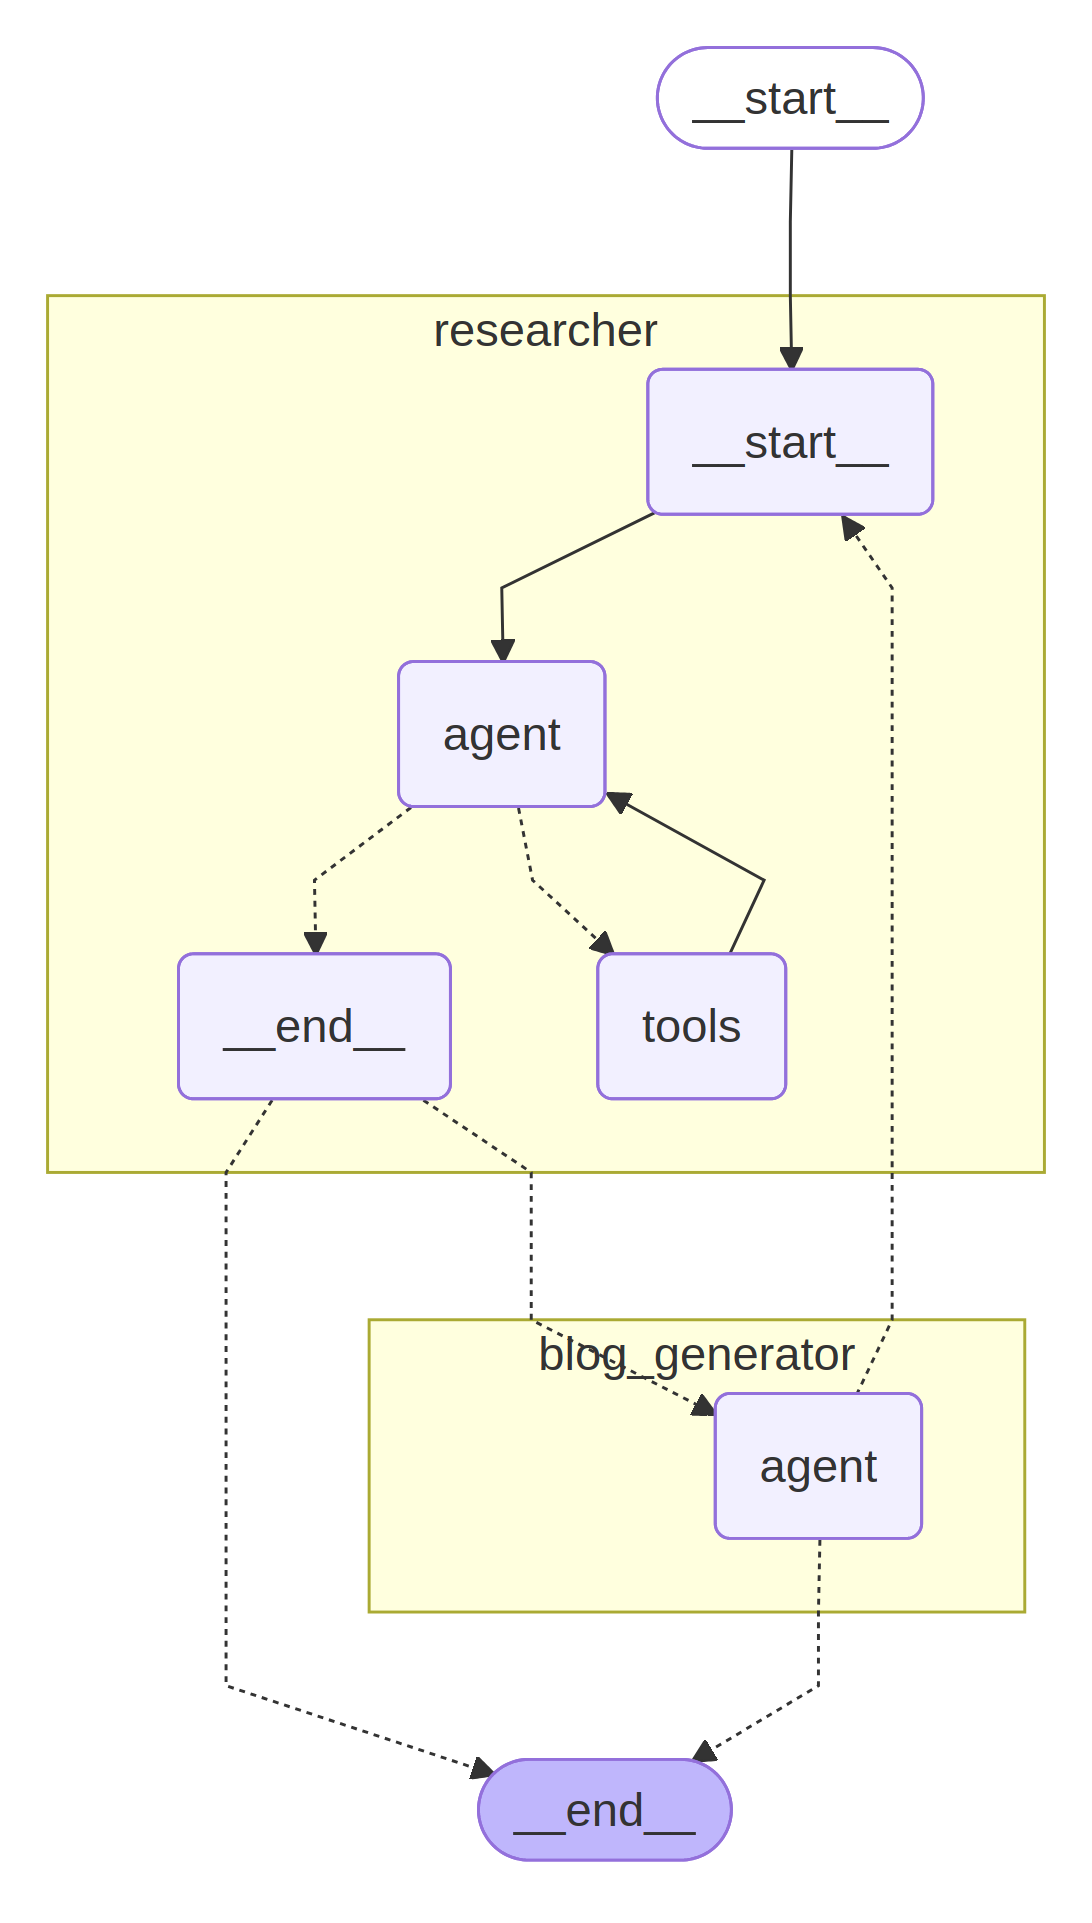

In [11]:
from langchain_core.runnables.graph import MermaidDrawMethod 

import nest_asyncio
nest_asyncio.apply()
# This is necessary to allow nested event loops in Jupyter notebooks

from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("blog_generator", blog_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()


# Visualize the workflow graph
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [12]:
response=graph.invoke({"messages":"Write a detailed blog on transformer variants in production deployments"})

In [13]:
response["messages"][-1].content

'FINAL ANSWER:Okay, I\'ve incorporated the feedback and added more practical elements, code snippets, and a section on monitoring and A/B testing. Here\'s the revised blog post outline:\n\n**Blog Post Title:** Transformer Variants in Production: A Practical Guide\n\n**Introduction**\n\n*   Briefly introduce Transformers and their impact on NLP and other fields (CV, etc.).\n*   Explain the challenges of deploying large Transformer models in production (resource constraints, latency, cost).\n*   Introduce the concept of Transformer variants and why they are essential for practical deployments.\n*   Mention the focus of the blog post: a practical guide to different Transformer variants, optimization techniques, and deployment strategies for various production scenarios.\n\n**Challenges of Deploying Transformers in Production**\n\n*   **Model Size and Computational Cost:** Discuss the large number of parameters in standard Transformers (e.g., BERT, GPT) and the associated computational req

In [14]:
print(response["messages"][-1].content)

FINAL ANSWER:Okay, I've incorporated the feedback and added more practical elements, code snippets, and a section on monitoring and A/B testing. Here's the revised blog post outline:

**Blog Post Title:** Transformer Variants in Production: A Practical Guide

**Introduction**

*   Briefly introduce Transformers and their impact on NLP and other fields (CV, etc.).
*   Explain the challenges of deploying large Transformer models in production (resource constraints, latency, cost).
*   Introduce the concept of Transformer variants and why they are essential for practical deployments.
*   Mention the focus of the blog post: a practical guide to different Transformer variants, optimization techniques, and deployment strategies for various production scenarios.

**Challenges of Deploying Transformers in Production**

*   **Model Size and Computational Cost:** Discuss the large number of parameters in standard Transformers (e.g., BERT, GPT) and the associated computational requirements (memor

### Multi Agent Suprvisor With RAG
Supervisor is a multi-agent architecture where specialized agents are coordinated by a central supervisor agent. The supervisor agent controls all communication flow and task delegation, making decisions about which agent to invoke based on the current context and task requirements.

In this tutorial, you will build a supervisor system with two agents — a research and a math expert. By the end of the tutorial you will:

1. Build specialized research and math agents
2. Build a supervisor for orchestrating them with the prebuilt langgraph-supervisor
3. Build a supervisor 
4. Implement advanced task delegation


In [15]:
internal_tool_1

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x7090143e60c0>)

In [16]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search

TavilySearch(max_results=3, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'), api_base_url=None))

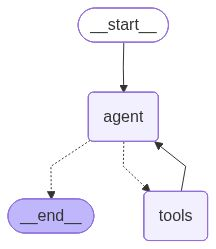

In [17]:
from langgraph.prebuilt import create_react_agent

research_agent=create_react_agent(
    model=llm,
    tools=[web_search,internal_tool_1],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent"
)
research_agent

In [18]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent=create_react_agent(
    model=llm,
    tools=[add,multiply,divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent"

)

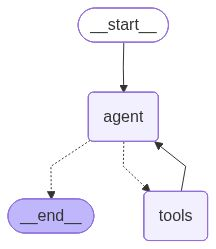

In [19]:
math_agent

In [33]:
from typing import TypeVar
from langgraph.pregel import Pregel

# Temporary compatibility patch for older LangGraph versions lacking generic support
if not hasattr(Pregel, "__class_getitem__") or not getattr(Pregel, "__parameters__", ()):
    _PregelState = TypeVar("_PregelState")
    def _pregel_class_getitem(cls, _item):
        return cls
    Pregel.__class_getitem__ = classmethod(_pregel_class_getitem)
    Pregel.__parameters__ = (_PregelState,)

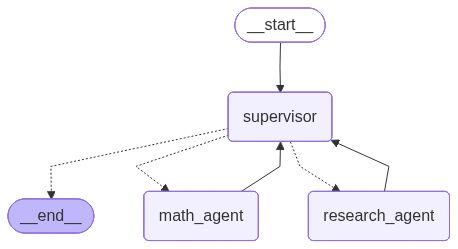

In [34]:
### create supervisor agent
from langgraph_supervisor import create_supervisor

supervisor=create_supervisor(
    model=llm,
    agents=[research_agent,math_agent],
    prompt=(
         "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."

    ),
    add_handoff_back_messages=True,
    output_mode="full_history"
).compile()

supervisor

In [38]:
test_response = supervisor.invoke({"messages": [HumanMessage(content="What is 12 times 8?")]})
test_response["messages"][-1].content

'12 times 8 is 96.'

In [45]:
response=supervisor.invoke({"messages":" what is newton's 2nd law of motion?"})

In [46]:
response

{'messages': [HumanMessage(content=" what is newton's 2nd law of motion?", additional_kwargs={}, response_metadata={}, id='2df1896e-d2cd-4847-a66c-10de8c6876af'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'transfer_to_research_agent', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, name='supervisor', id='run--4924def9-11d2-4639-932d-bf0addb2cf75-0', tool_calls=[{'name': 'transfer_to_research_agent', 'args': {}, 'id': 'd3da134c-2af4-4d1b-933c-8f884517b70a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 105, 'output_tokens': 7, 'total_tokens': 112, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='Successfully transferred to research_agent', name='transfer_to_research_agent', id='8eade026-9f41-46cd-bdb1-97dcc4d43d85', tool_call_id='d3da134c-2af4-4d1b-933c-8f884517b70a'),
  AIMessage(content='', additional_kwargs={'function_call': {'nam

In [47]:
import importlib.metadata
import importlib
import langgraph
importlib.reload(langgraph)
print(importlib.metadata.version("langgraph"))
# print(langgraph.__file__)

0.4.6


In [48]:
response["messages"][-1].content

'OK.'

### Hierarchical Agent Teams With RAG
In our previous example (Agent Supervisor), we introduced the concept of a single supervisor node to route work between different worker nodes.

But what if the job for a single worker becomes too complex? What if the number of workers becomes too large?

For some applications, the system may be more effective if work is distributed hierarchically.

You can do this by composing different subgraphs and creating a top-level supervisor, along with mid-level supervisors.

In [49]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

tavily_tool = TavilySearch(max_results=5)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [58]:
@tool
def scrape_webpages(urls:List[str])->str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )



In [50]:
# # Without using @tool
# from langgraph.prebuilt import ToolNode
# tools = ["tool1", "tool2", "tool3"]
# tool_node = ToolNode(tools)



In [51]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"

@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"

@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

In [52]:
WORKING_DIRECTORY

PosixPath('/tmp/tmpgkrgixjv')

In [53]:
# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

In [54]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages


class State(MessagesState):
    next: str

In [55]:
def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

In [56]:
internal_tool_1

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x7090143e60c0>)

In [60]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent



search_agent = create_react_agent(llm, tools=[tavily_tool,internal_tool_1])
search_agent

def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

### sub agent
web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])


def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

In [61]:
research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])
research_supervisor_node

<function __main__.make_supervisor_node.<locals>.supervisor_node(state: __main__.State) -> langgraph.types.Command[typing.Literal['search', 'web_scraper', '__end__']]>

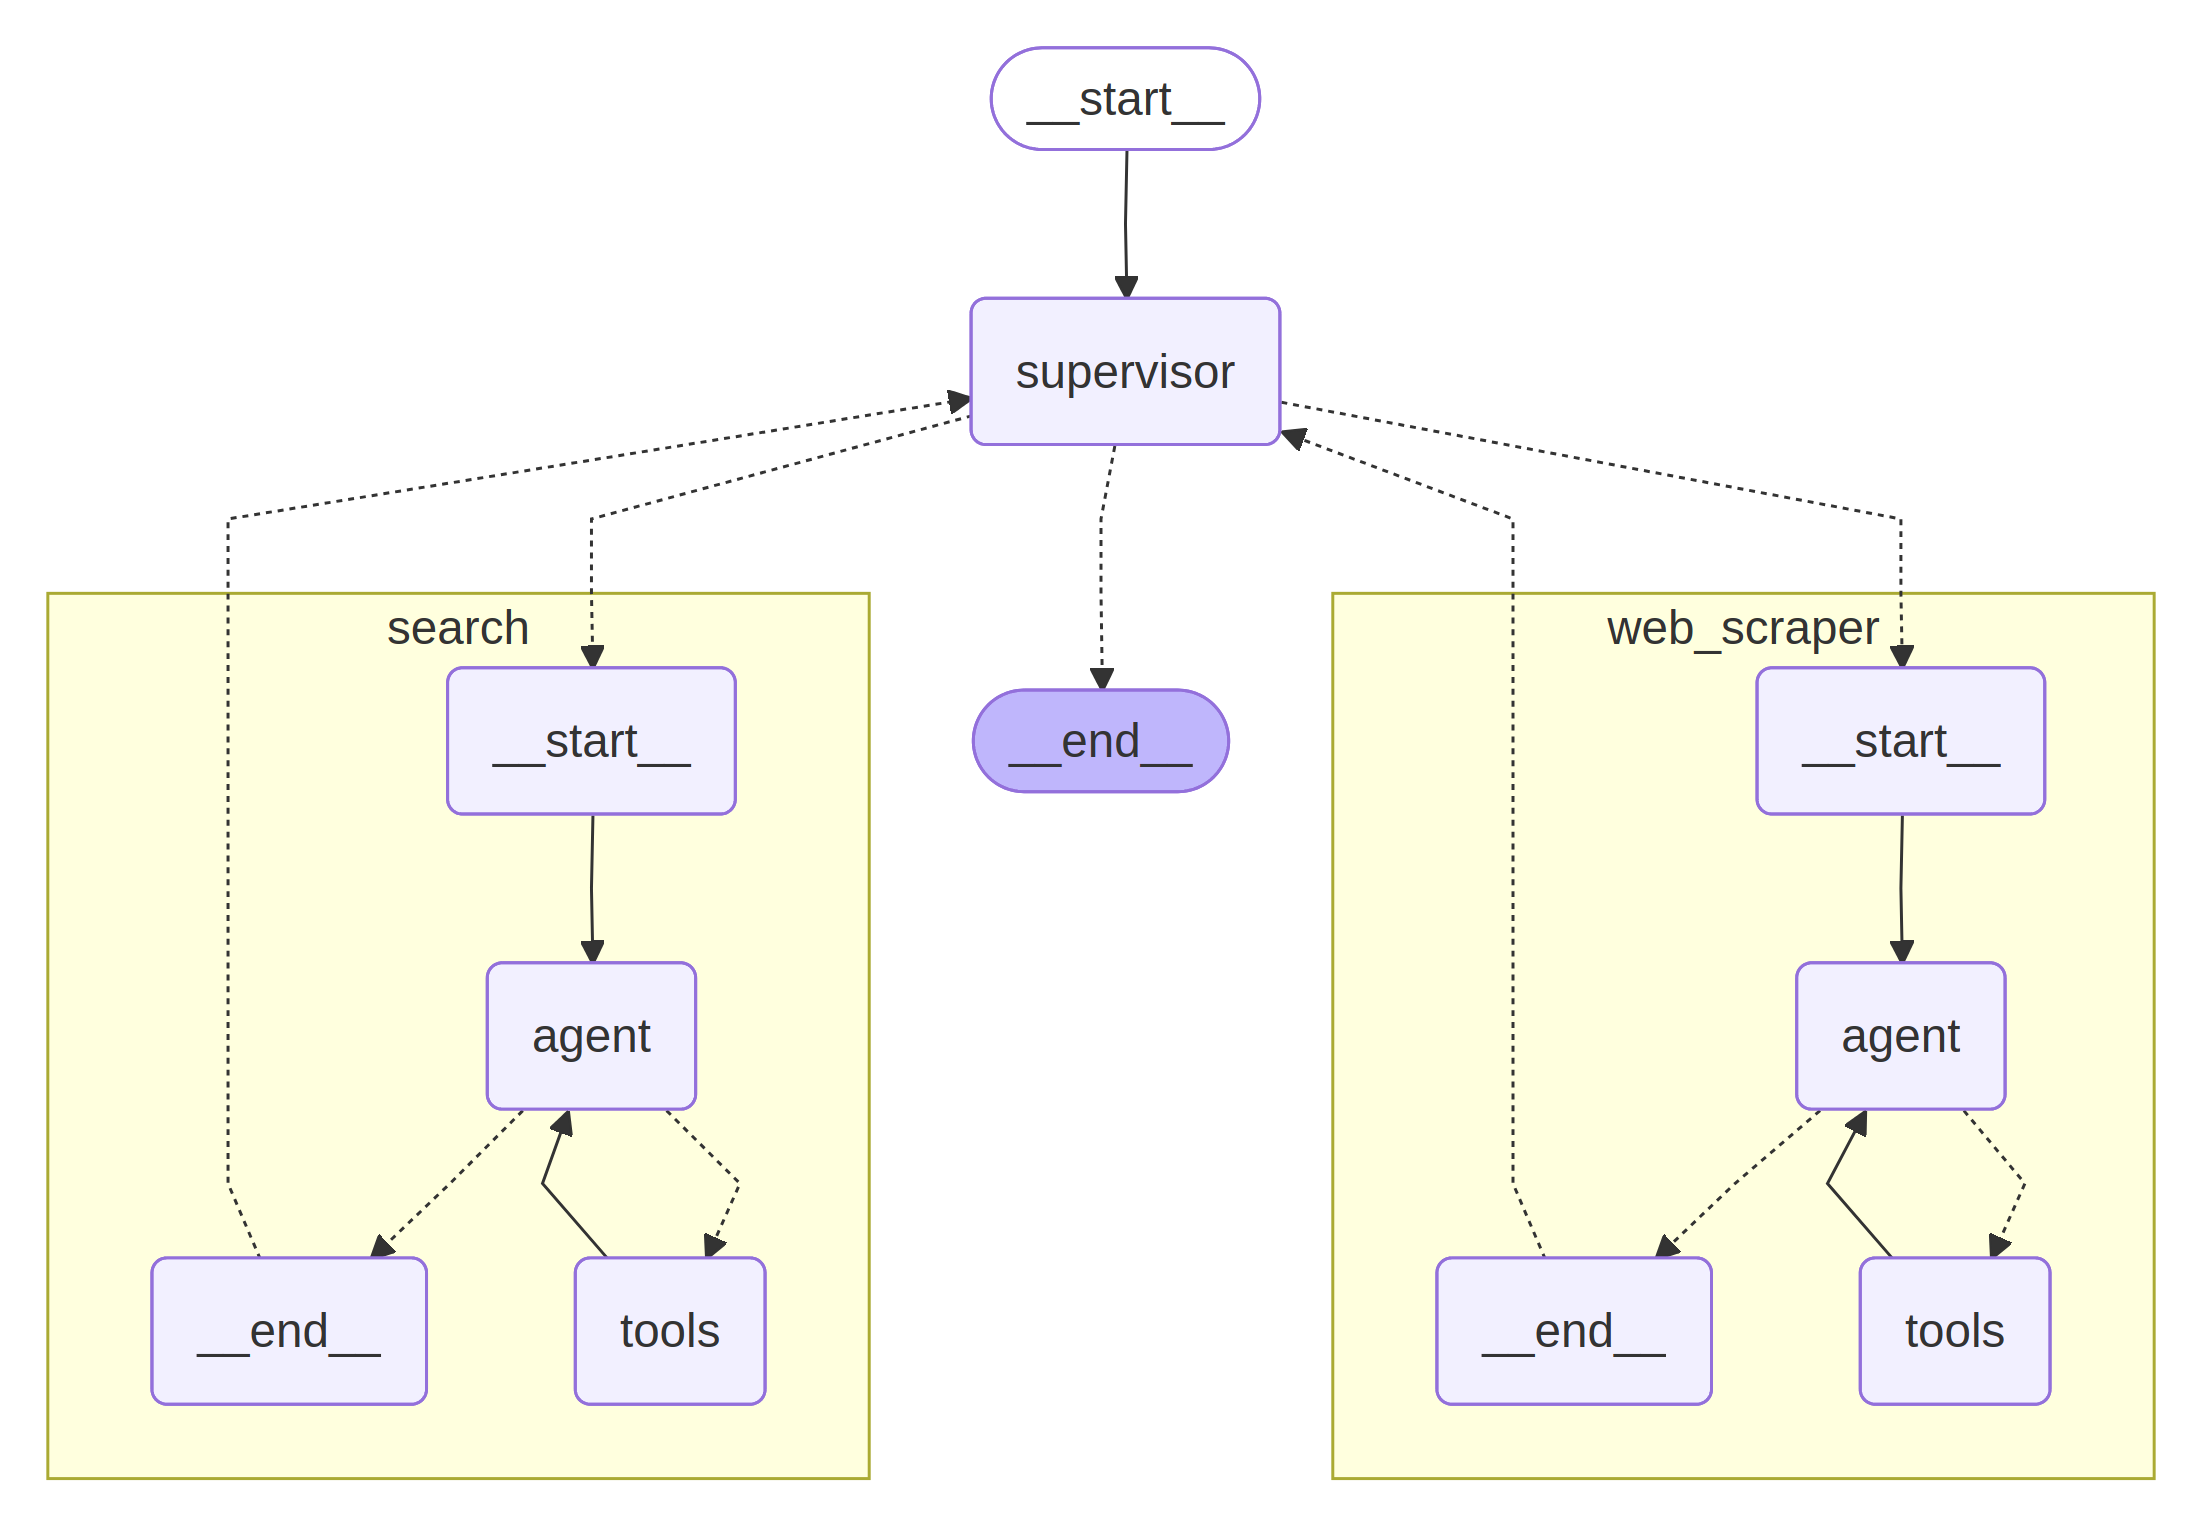

In [62]:
from langchain_core.runnables.graph import MermaidDrawMethod 

import nest_asyncio
nest_asyncio.apply()
# This is necessary to allow nested event loops in Jupyter notebooks


research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

# Visualize the workflow graph
from IPython.display import Image, display
display(Image(research_graph.get_graph(xray=True).draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [63]:
@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])

In [64]:
doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)


def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"])

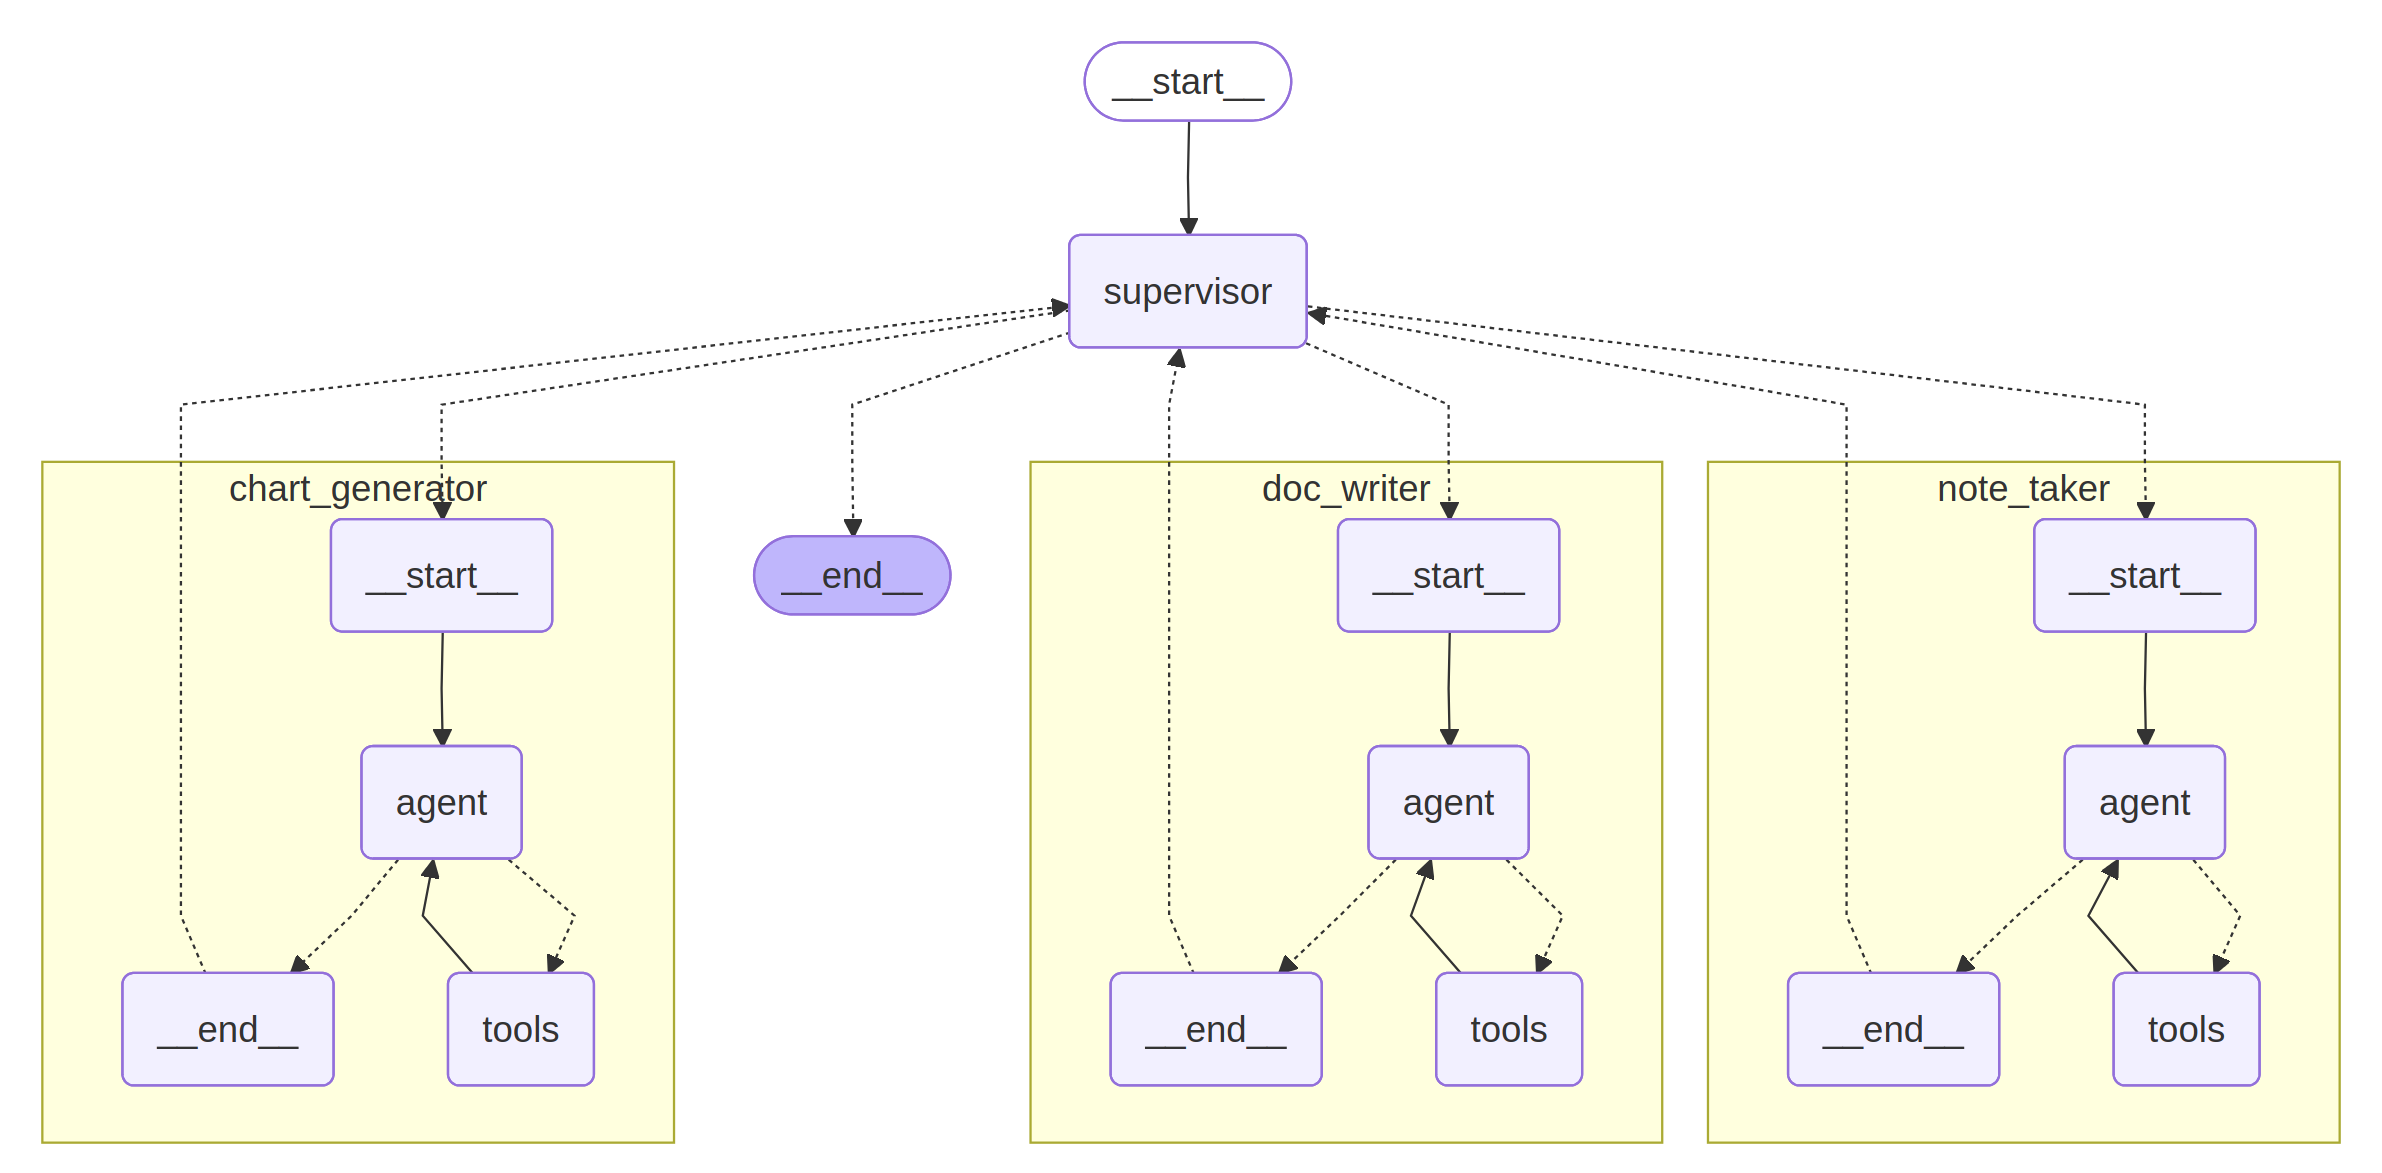

In [65]:
from langchain_core.runnables.graph import MermaidDrawMethod 

import nest_asyncio
nest_asyncio.apply()
# This is necessary to allow nested event loops in Jupyter notebooks


# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()
paper_writing_graph


# Visualize the workflow graph
from IPython.display import Image, display
display(Image(paper_writing_graph.get_graph(xray=True).draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [66]:
from langchain_core.messages import BaseMessage
teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])
teams_supervisor_node

<function __main__.make_supervisor_node.<locals>.supervisor_node(state: __main__.State) -> langgraph.types.Command[typing.Literal['research_team', 'writing_team', '__end__']]>

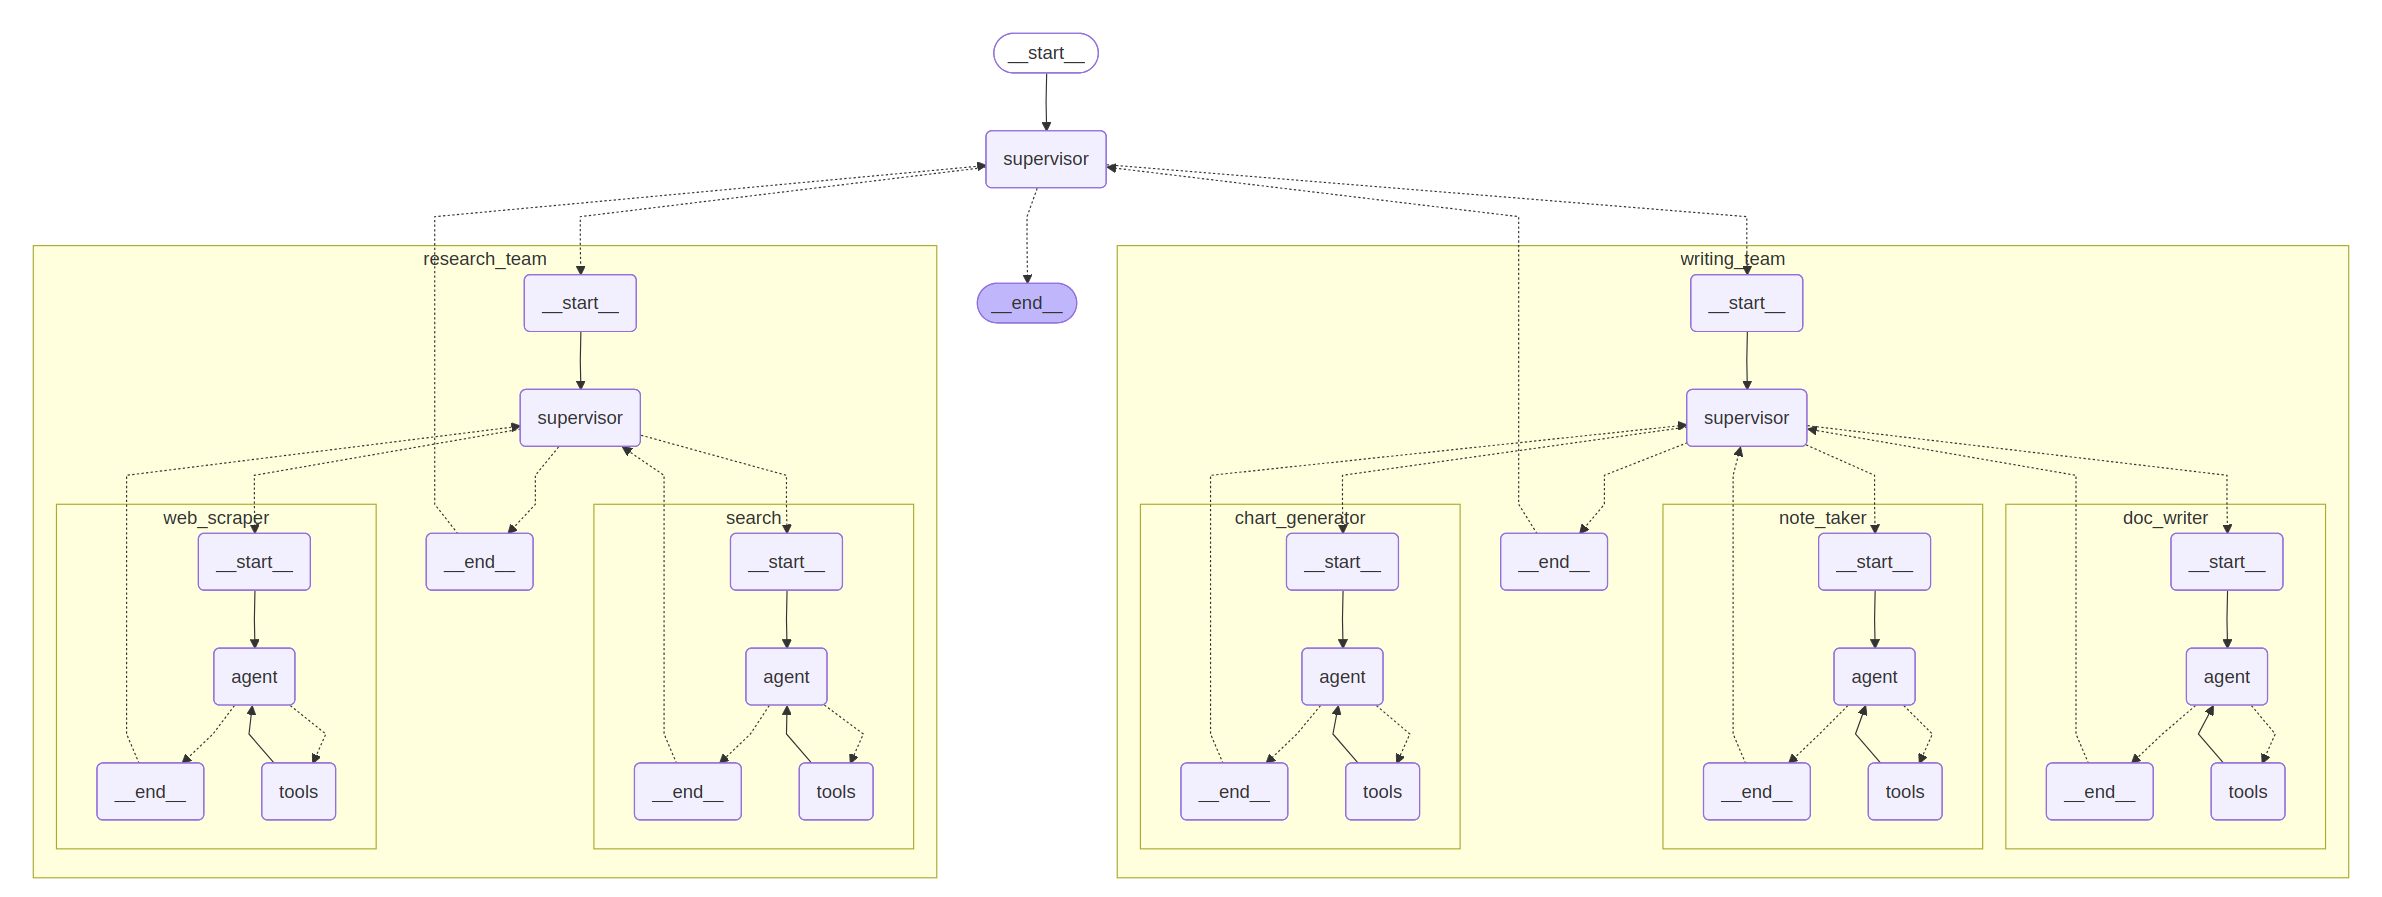

In [67]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )

from langchain_core.runnables.graph import MermaidDrawMethod 

import nest_asyncio
nest_asyncio.apply()
# This is necessary to allow nested event loops in Jupyter notebooks

# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()
super_graph

# Visualize the workflow graph
from IPython.display import Image, display
display(Image(super_graph.get_graph(xray=True).draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

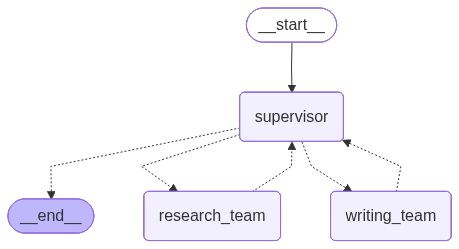

In [68]:
# super_graph in high level
super_graph

In [69]:
response=super_graph.invoke(
    {
        "messages": [
            ("user", "Write about transformer variants in production deployments.")
        ],
    })

ValueError: no signature found for builtin type <class 'dict'>

In [ ]:
response

In [ ]:
response["messages"][-1].content